# Importing all libraries

In [4]:
import os
os.chdir("G:\Nit Calicut\SEM2\PRA\SPML\CODE")


import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
import math
import cv2
import scipy.stats

def griddisplay(image_list,title):

    plt.figure()
    plt.suptitle(title, fontsize=16)
    n_row = 3
    n_col = 3
    for i in range(n_row * n_col):
           plt.subplot(n_row, n_col, i + 1)
           plt.imshow(image_list[i],cmap="gray")
           plt.xticks(())
           plt.yticks(())

# Read the dataset

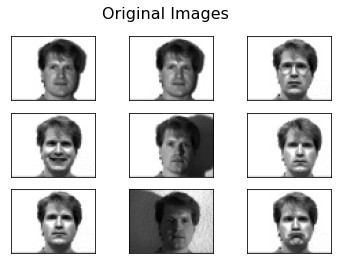

In [5]:
savePath = r"G:\Nit Calicut\SEM2\PRA\SPML\CODE\yaleImagesFinal";

import csv

with open(savePath + "\\" +"labels.csv", 'r') as f:
    data = list(csv.reader(f, delimiter=";"))
 
y = np.array(data)
y = np.array([int(label) for label in y])

imgs = []
flattened_images = []

for x in os.listdir(savePath):
    if "jpg" in x: 
        im = plt.imread(savePath + "\\" + x)
        imgs.append(im)
        flattened_images.append(im.flatten())

griddisplay(imgs,"Original Images")    

# Finding the mean face

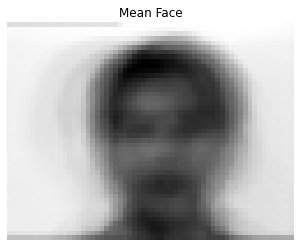

In [8]:
n_components = 100;

n_samples = len(imgs);

[h,w] = imgs[0].shape

A_transpose = np.matrix(flattened_images)
A = np.transpose(A_transpose)

# imgsData = imgsData.transpose()

meanTotal = np.mean(A,1)

MeanFace = meanTotal.reshape(h,w)
plt.figure()
plt.imshow(MeanFace,cmap=plt.cm.gray)
plt.axis('off')
plt.title('Mean Face')
plt.show()


# Project the given data on Principal Components

In [10]:
# PCA LOGIC 

zero_mean =[]
column =0
Zero_mean_matrix= np.ones((h*w,n_samples))


for values in flattened_images:
    #zm = values-mean
    zm= A[:,column] - meanTotal
    #print("z",zm.shape)
    zm = np.squeeze(zm)
    Zero_mean_matrix[:,column] = zm
    zm_images = zm.resize(h,w)
    zero_mean.append(zm)
    column = column +1

covarianceMtrx = (np.dot(Zero_mean_matrix,np.transpose(Zero_mean_matrix)))/(h*w)

eigen_vecsPCA, eigen_valsPCA, _ = scipy.linalg.svd(covarianceMtrx)

eigen_vecsPCA = eigen_vecsPCA[:,:n_components]

# project given data on PCA and then perform LDA




In [11]:
projectedData = np.dot(eigen_vecsPCA.T ,Zero_mean_matrix)

#    LDA LOGIC  - finding scatter matrices and then eigen values and vectors

In [13]:
meanProjectedData = np.mean(projectedData,1)

featureSize = projectedData.shape[0]

Sw = np.zeros([featureSize,featureSize])
Sb = np.zeros([featureSize,featureSize])
 
Xc = []
Xcdash = []
    
    
uniqueClasses = np.unique(y);

for c in uniqueClasses:
    
    indicesOfClasses = (np.where(y == c)[0])
  
    for index in  indicesOfClasses :
        Xc.append(projectedData[:,index])
       
    meanC = np.mean(Xc,axis = 0)
    
    centeredData = (Xc - meanC.reshape(meanProjectedData.shape).T)
    centeredMean = (meanC.reshape(meanProjectedData.shape) - meanProjectedData)
    
    Sw = Sw + np.dot (centeredData.T , centeredData)
    Sb = Sb +  np.dot (centeredMean.T , centeredMean)
    
    # check if matrix symmetric np.all(np.abs(Sw-Sw.T) < 1e-8)  

ldaMtrx = np.linalg.inv(Sw)* Sb    
  
eigen_vecsLDA, eigen_valsLDA, _ = scipy.linalg.svd(ldaMtrx)


eigenvectorsFinal = np.dot(eigen_vecsPCA,eigen_vecsLDA)
print(eigenvectorsFinal.shape)

(2914, 100)


In [14]:
projectedFischerData = np.dot(eigenvectorsFinal.T ,Zero_mean_matrix)

#  FISCHER FACES

Text(0.5, 0.98, 'First 10 FischerFaces')

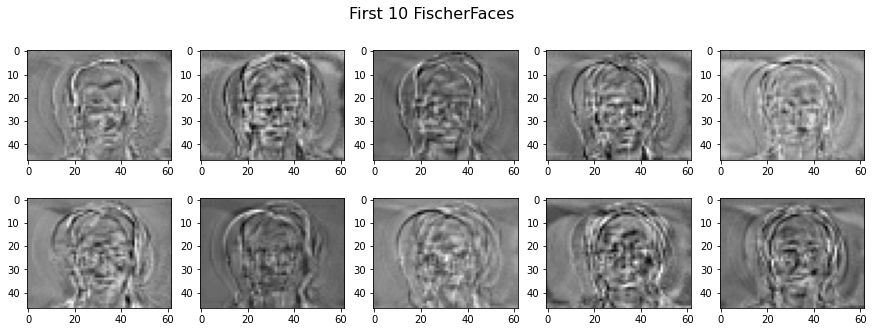

In [15]:

fig, axs = plt.subplots(1,3,figsize=(15,5))
for i in np.arange(10):
    ax = plt.subplot(2,5,i+1)
    img = eigenvectorsFinal[:,i].reshape(h,w)
    plt.imshow(img, cmap='gray')
fig.suptitle("First 10 FischerFaces", fontsize=16)

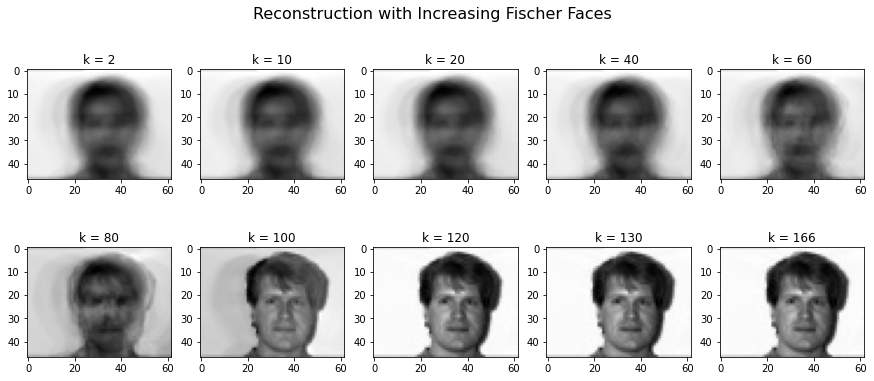

In [16]:
fig, axs = plt.subplots(5,2,figsize=(15,6))
for k, i in zip([1,9,19,39,59,79,99,119,129,165],np.arange(10)):
    # Reconstruct the first picture '1a.jpg' whose index is 0.
    weight = Zero_mean_matrix[:,1].dot(eigenvectorsFinal[:,:k]) # Get PC scores of the images
    projected_face = weight.dot(eigenvectorsFinal[:,:k].T) # Reconstruct first face in dataset using k PCs
    ax = plt.subplot(2,5,i+1)
    ax.set_title("k = "+str(k+1))
    plt.imshow(projected_face.reshape(h,w)+meanTotal.reshape(h,w),cmap='gray');
fig.suptitle(("Reconstruction with Increasing Fischer Faces"), fontsize=16);

# Test image

140


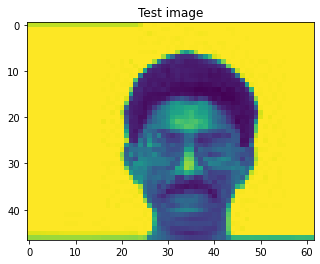

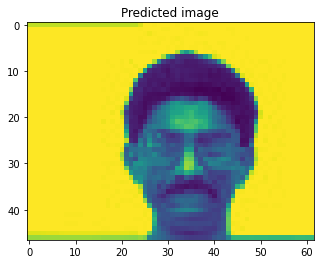

In [18]:
testImage = imgs[140]

plt.figure()
plt.title("Test image")
plt.imshow(testImage)

testImageData = testImage.flatten().reshape(h*w,1)
testImgCentered = testImageData - meanTotal


weightTest = (testImgCentered.T).dot(eigenvectorsFinal) 


euclideanDistanceArr = []

for i in range(n_samples):
    diff1 =(weightTest - projectedFischerData[:,i])
    euclideanDistance1 = math.sqrt(diff1.dot(diff1.T)) 
    euclideanDistanceArr.append(euclideanDistance1)    
    
best_match = np.argmin(euclideanDistanceArr)   
print(best_match)


plt.figure()
plt.title("Predicted image")
plt.imshow(imgs[best_match]) 